In [2]:
# paperspace gradient用
! git clone https://$$TOKEN@github.com/konnitiha3/MOD2NN.git

import sys
sys.path.append('/notebooks/MOD2NN')

fatal: destination path 'MOD2NN' already exists and is not an empty directory.


In [3]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from Faraday.two_dim.module.lib.layers import *
from Faraday.two_dim.module.lib import regularizer

In [98]:
mnist = tf.keras.datasets.mnist

(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train = x_train.astype("float32") / 255.0
x_test = x_test.astype("float32") / 255.0

y_train = y_train.astype("float32")
y_test = y_test.astype("float32")

# Reserve 10,000 samples for validation
x_val = x_train[-5000:]
y_val = y_train[-5000:]
x_train = x_train[:-5000]
y_train = y_train[:-5000]

In [118]:
#@title デフォルトのタイトル テキスト
wavelength = 633.0e-9 #@param {type:"number"}
d = 1.0e-6 #@param {type:"number"}
n = 1.5 #@param {type:"number"}
z = 0.1e-3 #@param {type:"number"}

def create_model(**kwargs):
    shape = (28, 28)
    theta = kwargs["theta"]
    eta = 0.
    tf.random.set_seed(kwargs["seed"])
    inputs = tf.keras.Input((28, 28))
    x = IntensityToElectricField(shape)(inputs)
    x = MO(shape, limitation=None, theta=theta, eta=eta)(x)
    x = AngularSpectrum(shape, wavelength=wavelength, z=z, d=d, n=n, method='expand', normalization="max")(x)
    x = ElectricFieldToIntensity(shape)(x)
    model = tf.keras.Model(inputs, x)
    return model

In [119]:
model = create_model(theta = np.pi/2, seed=1)
mo_layer = model.layers[2]

In [120]:
weights = mo_layer.get_weights()
spins1 = weights[0]
spins1 = np.where(spins1>0, 1, -1)
nw_spins1 = spins1.copy()
MCDISC = 10
history = []
images = []

kb = 1
T = 0.5

input = np.ones((1,28,28))
out = np.zeros_like(input)
out[:, 12:16, 12:16] = 1

for MC in range(MCDISC):
    for i in range(spins1.shape[0]):
        for j in range(spins1.shape[1]):
            pred1 = model.predict(input)
            E1 = np.sum((out-pred1[0])**2)

            nw_spin1 = -spins1[i,j]
            nw_spins1 = spins1.copy()
            nw_spins1[i, j] = nw_spin1
            weights[0] = nw_spins1
            mo_layer.set_weights(weights)

            pred2 = model.predict(input)
            Eg = np.sum((out-pred2[0])**2)

            dE = Eg-E1

            if dE<=0 :
                spins1[i,j] = nw_spin1
                images.append(pred2[0])
            else:
                r = np.random.normal([1])
                p = np.exp(-dE/(kb*T))
                if r <= p:
                    spins1[i,j] = nw_spin1
                    images.append(pred2[0])
                else:
                    images.append(pred1[0])

            history.append(dE)

    print(f'step:{MC}')

1/1 [==============================] - 0s 14ms/step
step:0
1/1 [==============================] - 0s 15ms/step
step:1
1/1 [==============================] - 0s 15ms/step
step:2
1/1 [==============================] - 0s 19ms/step
step:3
1/1 [==============================] - 0s 15ms/step
step:4
1/1 [==============================] - 0s 15ms/step
step:5
1/1 [==============================] - 0s 16ms/step
step:6
1/1 [==============================] - 0s 15ms/step
step:7
1/1 [==============================] - 0s 18ms/step
step:8
1/1 [==============================] - 0s 17ms/step
step:9


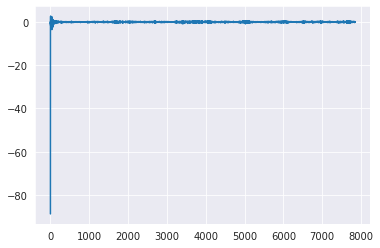

In [121]:
plt.plot(history)

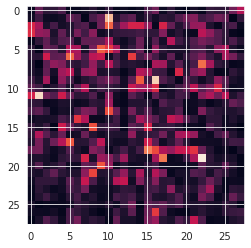

In [129]:
plt.imshow(images[0])